<img src="https://github.com/djp840/MSDS_458_Public/blob/main/images2/NorthwesternHeader.png?raw=1" />

## MSDS458 Research Assignment 1:


* In this notebook, we will build a `DNN` model for classifying MNIST digits. The `DNN` model will consist of 784 input nodes, a hidden layer with 128 nodes and 10 output nodes (corresponding to the 10 digits).
* We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation.
* After training and evaluating our `DNN` model we analyze its performance. In particular, we use confusion matrices to compare the `predicted classes` with the `class labels` to try to determine why some images were misclassified by the model.
* We then obtain the 60,000 `activation values` of one of the hidden nodes for the (original) set of training data. We want to use these `activation values` as "proxies" for the predicted classes of the 60,000 images.
* And just like we compared the `predicted classes` with the `class labels` using confusion matrices to determine the efficacy of the model, we use `box plots` to visualize the relationship between the `activation values` of one hidden node and the `class labels`. We don't expect these activation values to have much "predictive power". In fact, the same activation values can be associated with multiple class labels resulting in a lot of overlap in the `box plots`.
*  Finally, we use a Random Forest Classifier to find the relative importance of the 784 features (pixels) in the training set. We then select the 70 most important feature (pixels) from the training, validation and test images to test our 'best' model on.



## Importing Packages

* First we import all the packages that will be used in the assignment.

* Since Keras is integrated in TensorFlow 2.x, we import `keras` from `tensorflow` and use `tenserflow.keras.xxx` to import all other Keras packages. The seed argument produces a deterministic sequence of tensors across multiple calls.

In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as kb
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)


## Verify TensorFlow version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.19.0


In [4]:
import sys
print(sys.version)

3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]


## Research Assignment Reporting Functions

In [5]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

    return mtx

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

## Loading MNIST Dataset

* The MNIST dataset of handwritten digits has a training set of 60,000 images, and a test set of 10,000 images. It comes prepackaged as part of `tf.Keras`. Use the `tf.keras.datasets.mnist.load_data` to the get these datasets (and the corresponding labels) as Numpy arrays.

In [6]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()
print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train:	(60000, 28, 28)
y_train:	(60000,)
x_test:		(10000, 28, 28)
y_test:		(10000,)


* Tuples of Numpy arrays: `(x_train, y_train)`, `(x_test, y_test)`
* `x_train`, `x_test`: uint8 arrays of grayscale image data with shapes (num_samples, 28, 28).
* `y_train`, `y_test`: uint8 arrays of digit labels (integers in range 0-9)

##  Preprocessing Data

* Before we build our model, we need to prepare the data into the shape the network expected
* More specifically, we will convert the labels (integers 0 to 9) to 1D numpy arrays of shape (10,) with elements 0s and 1s.
* We also reshape the images from 2D arrays of shape (28,28) to 1D *float32* arrays of shape (784,) and then rescale their elements to values between 0 and 1.

### Apply one-hot encoding on the labels

We will change the way the labels are represented from numbers (0 to 9) to vectors (1D arrays) of shape (10, ) with all the elements set to 0 except the one which the label belongs to - which will be set to 1. For example:


| original label | one-hot encoded label |
|------|------|
| 5 | [0 0 0 0 0 1 0 0 0 0] |
| 7 | [0 0 0 0 0 0 0 1 0 0] |
| 1 | [0 1 0 0 0 0 0 0 0 0] |

In [7]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:10,]))

First ten entries of y_train:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


### Reshape the images to 1D arrays

Reshape the images from shape (28, 28) 2D arrays to shape (784, ) vectors (1D arrays).

In [8]:
# Reshape the images:
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))


1. Each element in an image is a pixel value
2. Pixel values range from 0 to 255
3. 0 = White
4. 255 = Black

### Rescale the elements of the reshaped images

Rescale the elements between [0 and 1]

In [9]:
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

# Experiment 1:

* Our `dense neural network` will consist of 784 input nodes, a hidden layer with `1 node` and 10 output nodes (corresponding to the 10 digits). We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation.
* After training the model, we group the 60,000 `activation values` of the hidden node for the (original) set of training images by the 10 predicted classes and visualize these sets of values using a `boxplot`. We expect the overlap between the range of values in the "boxes" to be minimal.
* In addition, we find the pattern that maximally activates the hidden node as a "warm up" exercise for similar analysis we will perform on CNN models in Assignment 2

##  1.1 Create the DNN Model


### Build the DNN model

* We create a `dense neural network` consisting of `784 input nodes`, a hidden layer with `1 node` and `10 output nodes`.

In [10]:
kb.clear_session()
model = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

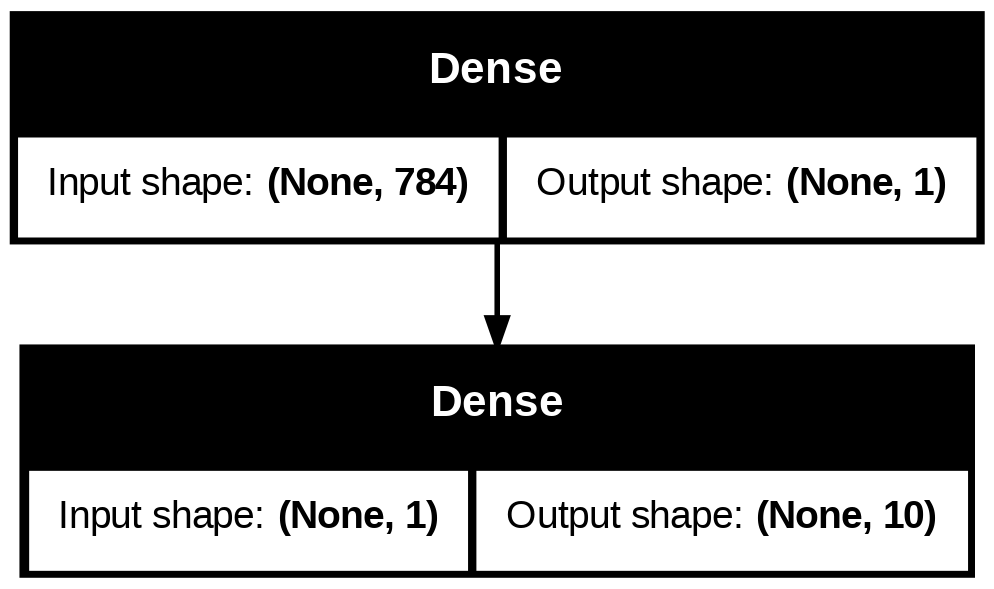

In [11]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True)

### Compile the DNN model

* We use `stochastic gradient descent`.

* Regarding loss function, we use `categorical cross entropy`, which is commonly used in multi-class classification problem.

* Finally, we will use the `accuracy` during training as a metric to keep track of as the model trains.

In [12]:
model.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

### Train the DNN model

In [13]:
history = model.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split = 5000 / 60000
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model_1.keras",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1982 - loss: 2.0939 - val_accuracy: 0.2562 - val_loss: 1.8371
Epoch 2/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2503 - loss: 1.8278 - val_accuracy: 0.2610 - val_loss: 1.7605
Epoch 3/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2706 - loss: 1.7738 - val_accuracy: 0.3122 - val_loss: 1.7364
Epoch 4/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2976 - loss: 1.7486 - val_accuracy: 0.3310 - val_loss: 1.7169
Epoch 5/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3126 - loss: 1.7355 - val_accuracy: 0.3370 - val_loss: 1.7039
Epoch 6/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3176 - loss: 1.7273 - val_accuracy: 0.3308 - val_loss: 1.6966
Epoch 7/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3247 - loss: 1.7139 - val_accuracy: 0.3426 - val_loss: 1.6844
Epoch 8/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3315 - loss: 1

### Evaluate the DNN model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [14]:
model = tf.keras.models.load_model("DNN_model_1.keras", custom_objects={'softmax_v2': tf.keras.activations.softmax})
print(f"Test acc: {model.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3413 - loss: 1.7412
Test acc: 0.346


*Dense Neural Network with one node in hidden layer is ineffective*

## 1.2 Analyzing the Activation Values of the Hidden Nodes

We want to examine the contribution of the individual hidden node to the classifications made by the model. We first get the activation values of all the hidden **node** for each of the 60,000 training images and treat these `1 activations` as the features that determine the classification class

Our goal is to use `box plots` to visualize how these activation correlate with the class labels.


 ### Get Activation Values of the Hidden Node (1)

To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [15]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.inputs, outputs=layer_outputs)

# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 ### Create a dataframe with the activation values and the class labels

In [16]:
#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}

activation_data[f"act_val_0"] = hidden_layer_activation[:,0]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.000,0.0,4.000,1.0,9.000,2.0,1.0,3.0,1.0,4.000,3.0,5.0,3.0,6.000,1.0
act_val_0,0.193,0.0,2.087,0.0,2.139,0.0,0.0,0.0,0.0,2.963,0.0,0.0,0.0,5.368,0.0


 ### Visualize the activation values with boxplots

We get the activation values of the first hidden node and combine them with the corresponding class labels into a DataFrame. We use both `matplotlib` and `seaborn` to create boxplots from the dataframe.

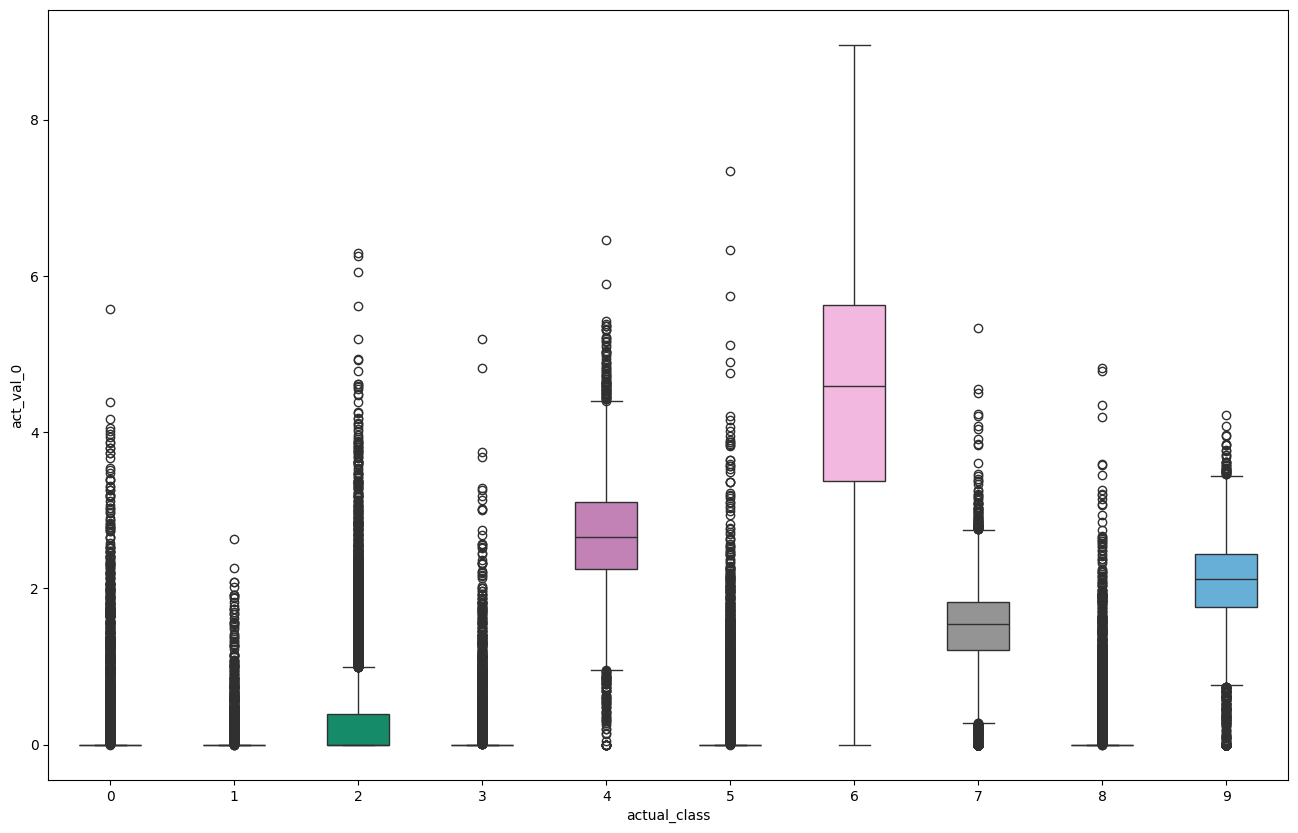

In [17]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
act_val = 'act_val_0'
plt.figure(figsize=(16,10))
bplot = sns.boxplot(y=act_val, x='actual_class',
                 data=activation_df[[act_val,'actual_class']],
                 width=0.5,
                 palette="colorblind")

### Displaying The Range Of Activation Values For Each Class Labels

In [18]:
activation_df.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

,actual_class,range_of_act_values
0,0,"[0.0, 5.57]"
1,1,"[0.0, 2.63]"
2,2,"[0.0, 6.29]"
3,3,"[0.0, 5.19]"
4,4,"[0.0, 6.46]"
5,5,"[0.0, 7.35]"
6,6,"[0.0, 8.96]"
7,7,"[0.0, 5.33]"
8,8,"[0.0, 4.82]"
9,9,"[0.0, 4.22]"


# Experiment 2:
* This time our `dense neural network` will have 784 input nodes, a hidden layer with `2 nodes` and `10 output nodes` (corresponding to the 10 digits).
* For each of the 60,000 images, the output of the two hidden nodes are plotted using a scatterplot. We color code the points according to which of the 10 classes the the output of the two nodes predicts. Ideally, just like in `EXPERIMENT 1` the color clusters should have very little overlap.
* Also compare the accuracy % & confusion matrix of Experiments 1 & 2. Again, the goal is to get more insights

## 2.1 Create DNN model with 2 hidden nodes.


In [19]:
# Build Model
kb.clear_session()
model = Sequential([
    Dense(input_shape=[784], units=2, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Complie Model
model.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

#Train Model
history = model.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split = 5000 / 60000
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model_2.keras",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

# Evaluate
model = tf.keras.models.load_model("DNN_model_2.keras", custom_objects={'softmax_v2': tf.keras.activations.softmax})
print(f"Test acc: {model.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")


Epoch 1/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2829 - loss: 1.8646 - val_accuracy: 0.4924 - val_loss: 1.4856
Epoch 2/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4793 - loss: 1.4963 - val_accuracy: 0.5448 - val_loss: 1.3700
Epoch 3/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5151 - loss: 1.4114 - val_accuracy: 0.5618 - val_loss: 1.3119
Epoch 4/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5459 - loss: 1.3518 - val_accuracy: 0.6176 - val_loss: 1.2323
Epoch 5/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5849 - loss: 1.2862 - val_accuracy: 0.6248 - val_loss: 1.1700
Epoch 6/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5983 - loss: 1.2285 - val_accuracy: 0.6284 - val_loss: 1.1435
Epoch 7/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6020 - loss: 1.2204 - val_accuracy: 0.6364 - val_loss: 1.1284
Epoch 8/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6079 - loss: 1

## 2.2 Analyzing the Activation Values of the Hidden Nodes

### Use a scatter plot to visualize the predicive power of the activation values

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


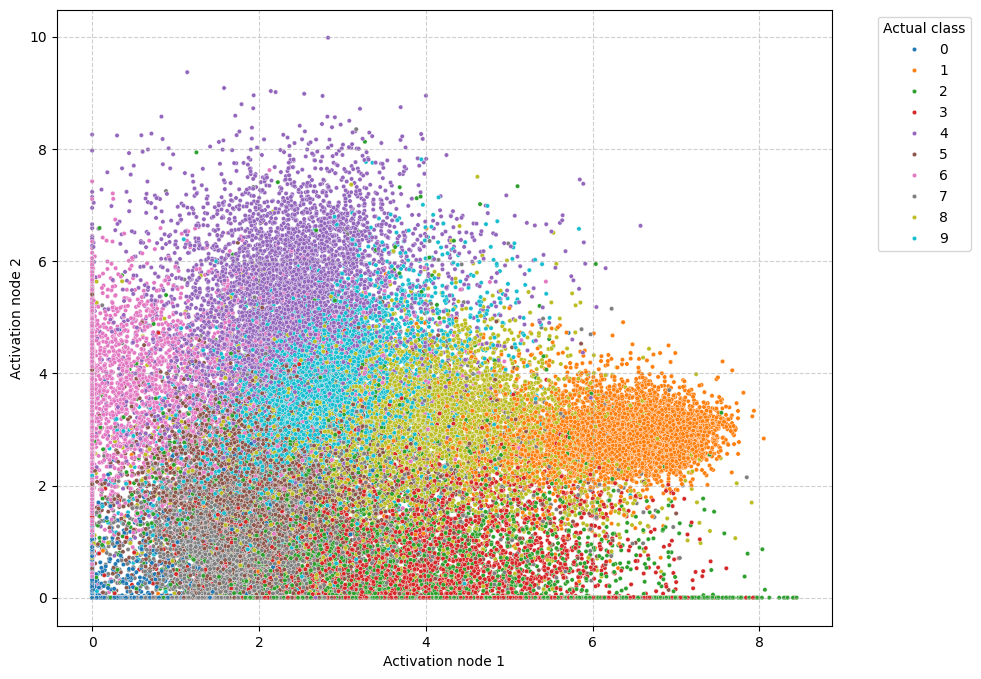

In [20]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.inputs, outputs=layer_outputs)


activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]


plt.figure(figsize=(10, 8))
sns.scatterplot(x=hidden_layer_activation[:, 0], y=hidden_layer_activation[:, 1], hue=y_train, palette='tab10', legend='full', s=10)
plt.xlabel('Activation node 1')
plt.ylabel('Activation node 2')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Actual class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## 2.2 Compare the accuracy(%) and confusion matrix between experiment 1 and experiment 2


### Accuracy



In [21]:
model_1 = tf.keras.models.load_model("DNN_model_1.keras", custom_objects={'softmax_v2': tf.keras.activations.softmax})
model_2 = tf.keras.models.load_model("DNN_model_2.keras", custom_objects={'softmax_v2': tf.keras.activations.softmax})
print_validation_report(y_test, np.argmax(model_1.predict(x_test_norm), axis=-1))
print_validation_report(y_test, np.argmax(model_2.predict(x_test_norm), axis=-1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.13      0.01      0.02       980
           1       0.21      0.96      0.34      1135
           2       0.16      0.08      0.10      1032
           3       0.00      0.00      0.00      1010
           4       0.50      0.53      0.51       982
           5       0.00      0.00      0.00       892
           6       0.82      0.78      0.80       958
           7       0.46      0.76      0.57      1028
           8       0.00      0.00      0.00       974
           9       0.46      0.23      0.31      1009

    accuracy                           0.35     10000
   macro avg       0.27      0.33      0.27     10000
weighted avg       0.27      0.35      0.27     10000

Accuracy Score: 0.3461
Root Mean Square Error: 3.06452280135097
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report
              precision    recall  f1-score   suppo

**Comparision**
* The model with `1 hidden node` performs poorly, achieving an overall accuracy of only `34.61%`.
* Many classes (digits **2, 4, 5, 8, 9**) show `zero precision and recall`, meaning the model essentially failed to recognize them.
* The performance is heavily skewed toward a few classes like **0, 1, 3, and 7**, but even then, the precision and recall values are inconsistent.
* This indicates that the model is `underfitting` and `lacks the representational power` needed to capture the complexity of the data.

___
* The model with 2 hidden nodes shows a substantial improvement, reaching `61.91% accuracy`.
* Precision, recall, and F1-scores are `balanced across most classes`.
* The model performing especially well on digits like **0, 1, 4, 6,** and **7**.
* Performance on classes such as **5** and **8** is weaker, every class now has some level of recognition, unlike the 1-hidden-node model.
* The `lower RMSE` (2.26 vs 3.06) also confirms better predictive accuracy.
___

Inconclusion, adding just one more hidden node significantly enhances the model’s learning capacity, reducing underfitting and leading to more reliable classification across all classes. However, the accuracy is still far from optimal, suggesting that deeper architectures or other improvements (e.g., more hidden nodes, regularization, or better training strategies) are needed.

### Confusion matrix

**Confusion Matrix 1**

Confusion Matrix for Experiment 1
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[  12,  846,   44,    0,   13,    0,    2,   58,    0,    5],
       [  12, 1085,   30,    0,    2,    0,    0,    6,    0,    0],
       [  24,  772,   81,    0,   32,    0,   13,   96,    0,   14],
       [   7,  934,   36,    0,    4,    0,    0,   29,    0,    0],
       [   0,    1,    6,    0,  523,    0,  139,  155,    0,  158],
       [  12,  708,   98,    0,    5,    0,    2,   61,    0,    6],
       [   1,   19,   21,    0,   96,    0,  746,   53,    0,   22],
       [   4,   46,   82,    0,   46,    0,    3,  780,    0,   67],
       [  13,  774,  101,    0,    6,    0,    2,   72,    0,    6],
       [   5,   33,   17,    0,  324,    0,    5,  391,    0,  234]])

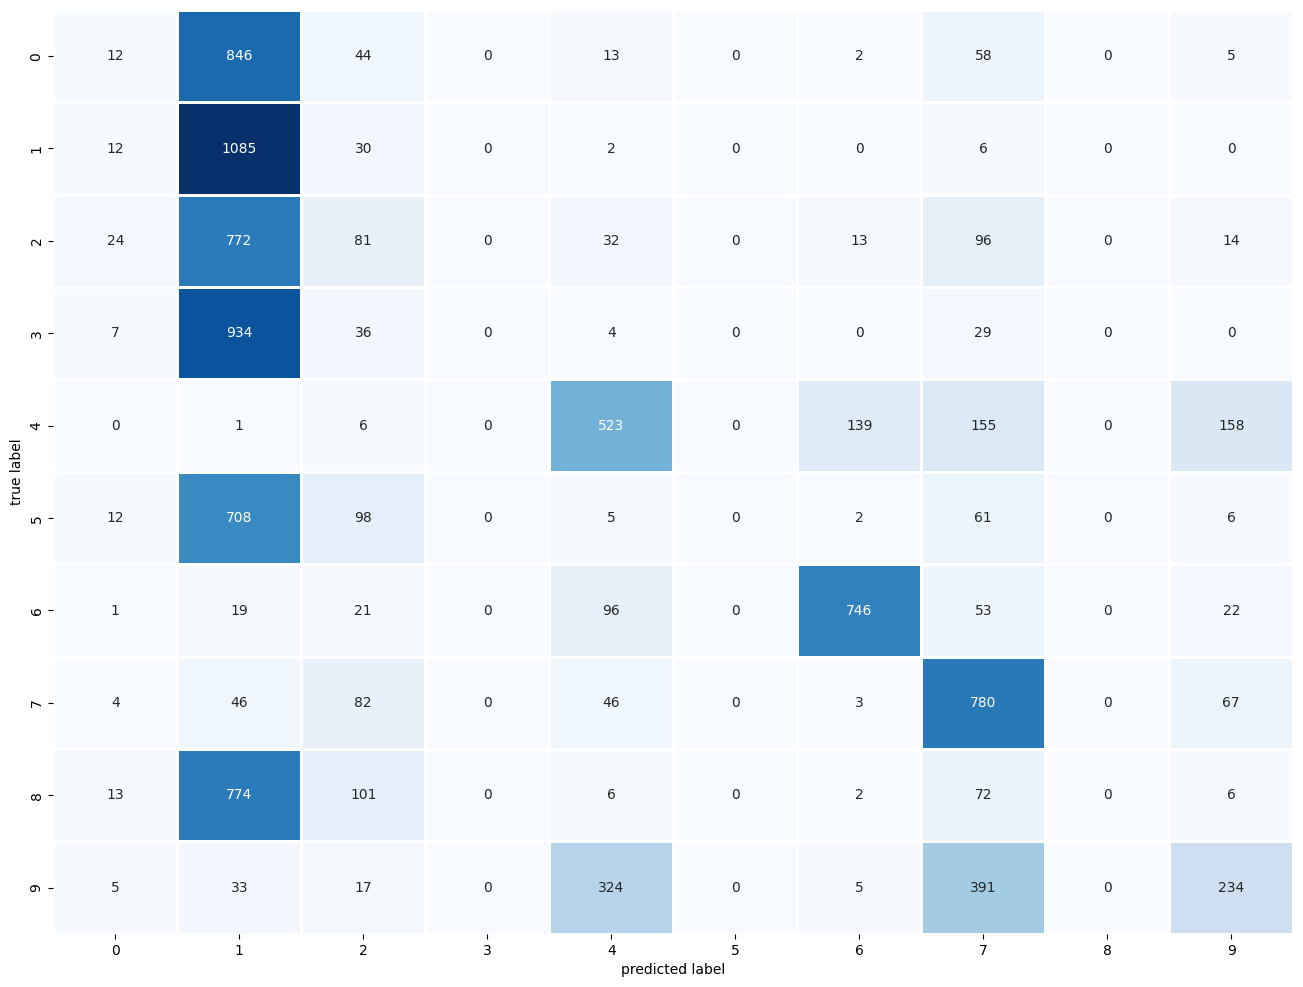

In [22]:
print('Confusion Matrix for Experiment 1')
plot_confusion_matrix(y_test, np.argmax(model_1.predict(x_test_norm), axis=-1))

**Confusion Matrix 2**

Confusion Matrix for Experiment 2
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[ 900,    0,    2,    1,    0,    3,   17,   56,    1,    0],
       [   0, 1075,    3,    3,    0,    8,    0,    2,   43,    1],
       [  32,   33,  206,  509,    6,   34,   15,  145,   35,   17],
       [  11,   46,  218,  572,    1,   16,    1,  106,   35,    4],
       [   1,    2,    0,    0,  762,   10,   70,    2,   27,  108],
       [  36,    6,   57,   20,   21,  294,   65,  258,   38,   97],
       [  53,    1,    1,    0,   70,   18,  780,    1,    9,   25],
       [  76,   22,   82,   29,    7,  135,   25,  578,   46,   28],
       [   5,  101,   37,   23,   38,   70,   15,   40,  461,  184],
       [   6,    4,    6,    4,  221,   67,   29,   15,   94,  563]])

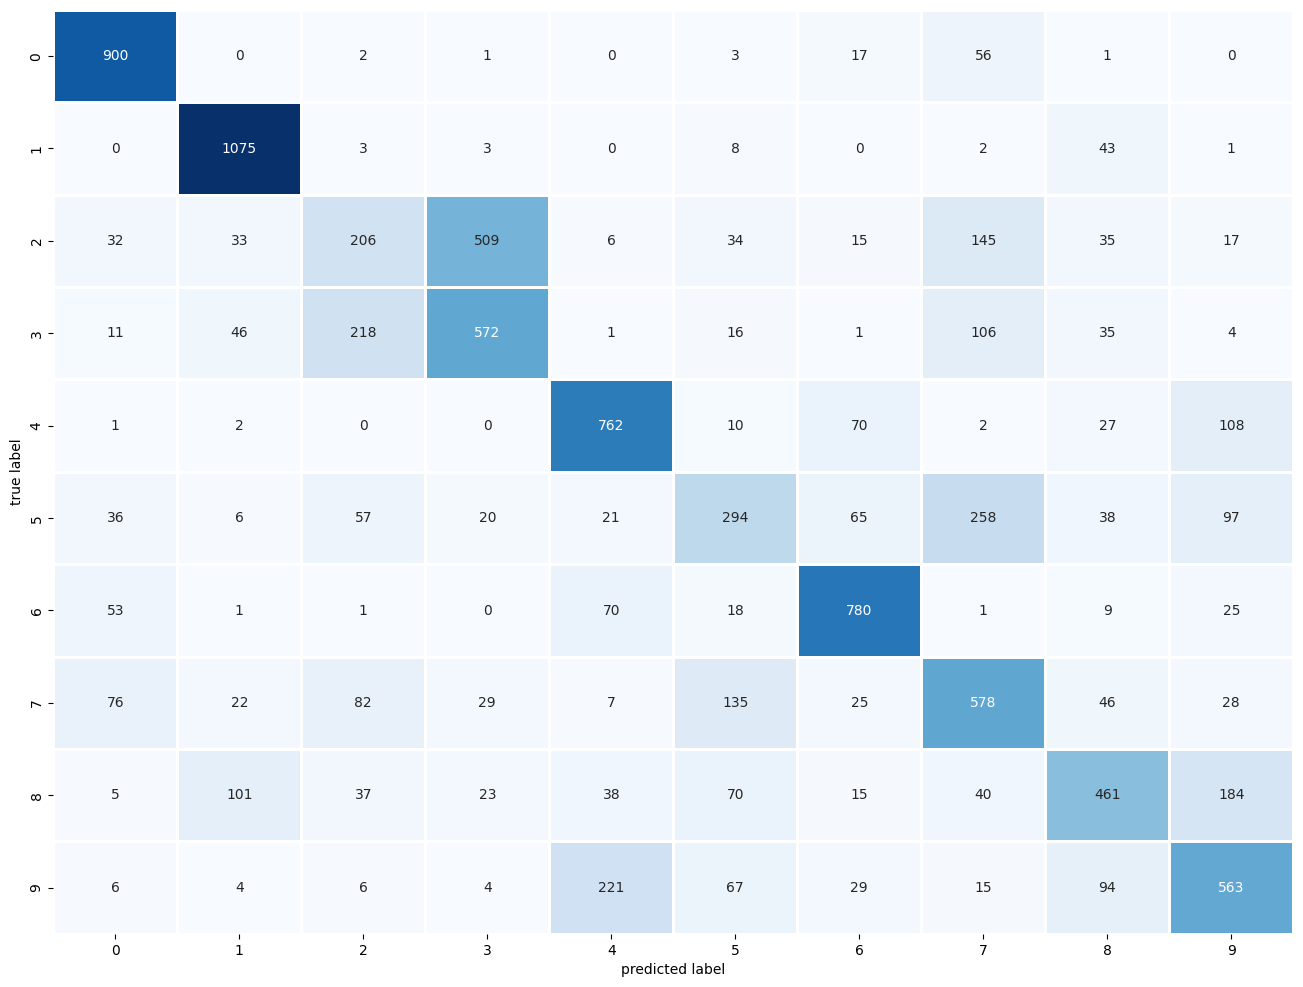

In [23]:
print('Confusion Matrix for Experiment 2')
plot_confusion_matrix(y_test, np.argmax(model_2.predict(x_test_norm), axis=-1))

**Comparision**

* For the `1-hidden-node` model, the matrix shows a strong bias toward predicting a limited subset of digits (notably **0, 1, 3, 4,** and **7**), while many other classes (such as **2, 5, 6, 8**, and **9**) are heavily misclassified.
* For example, digit “**2**” is frequently misclassified as “**3**” or “**6**”, and digit “**9**” is mostly confused with “**7**”. This reflects the poor per-class precision and recall observed in the report, with several classes having nearly zero recognition.

___

* The `2-hidden-node` model produces a much more balanced confusion matrix. Correct predictions are stronger across nearly all classes, with dense diagonal values visible for digits such as **0, 1, 3, 4, 6,** and **7**.
* Misclassifications are still present—for example, digits “**5**” and “**8**” show significant confusion with neighboring classes—but every digit now has a meaningful level of correct recognition. This aligns with the improved classification report, where precision and recall are consistently higher across the majority of classes, leading to a `67%` overall accuracy compared to only `37%` with a single hidden node.

# Experiment 3
Explore with more hidden nodes. Then end up with 1 'final' model. Say the 'best' model.


## 3.1 Define a model with abitrary hidden node and return the accuracy of that model



In [24]:
def evaluate_with_hidden_nodes(num_hidden_nodes):
  # Build Model
  kb.clear_session()
  model = Sequential([
      Dense(input_shape=[784], units=num_hidden_nodes, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
      Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
  ])

  # Complie Model
  model.compile(optimizer='rmsprop',
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

  #Train Model
  history = model.fit(
      x_train_norm
      ,y_train_encoded
      ,epochs = 200
      ,validation_split = 5000 / 60000
      ,callbacks=[tf.keras.callbacks.ModelCheckpoint(f"DNN_model_{num_hidden_nodes}.keras",save_best_only=True,save_weights_only=False)
                  ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
      )
  test_loss, test_acc = model.evaluate(x_test_norm, y_test_encoded)
  return test_acc


You can try some value of number of hidden nodes and take the best one.

In [25]:
candidates = [16, 32, 64, 128, 256, 512]
accuracies = []

for candidate in candidates:
  accuracies.append(evaluate_with_hidden_nodes(candidate))
best_index = accuracies.index(max(accuracies))
best_candidate = candidates[best_index]
best_accuracy = accuracies[best_index]

print('The best candidate is: {} with accuracy: {}'.format(best_candidate, best_accuracy))

Epoch 1/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7982 - loss: 0.7636 - val_accuracy: 0.9310 - val_loss: 0.2870
Epoch 2/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9154 - loss: 0.3484 - val_accuracy: 0.9382 - val_loss: 0.2665
Epoch 3/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9242 - loss: 0.3149 - val_accuracy: 0.9428 - val_loss: 0.2524
Epoch 4/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9296 - loss: 0.2968 - val_accuracy: 0.9458 - val_loss: 0.2400
Epoch 5/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9338 - loss: 0.2777 - val_accuracy: 0.9486 - val_loss: 0.2339
Epoch 6/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9372 - loss: 0.2606 - val_accuracy: 0.9560 - val_loss: 0.2175
Epoch 7/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9394 - loss: 0.2553 - val_accuracy: 0.9528 - val_loss: 0.2175
Epoch 8/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9408 - loss: 0

In [26]:
df = pd.DataFrame({
    'Hidden Nodes': candidates,
    'Accuracy': accuracies
})
print(df)

   Hidden Nodes  Accuracy
0            16    0.9379
1            32    0.9649
2            64    0.9626
3           128    0.9658
4           256    0.9633
5           512    0.9569


#

# Experiment 4
* Use PCA decomposition to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images from 784 to 154 (with 95% of training images variance lying along these components). We also reduce the number of dimensions of 'best' model from **Experiment 3** to 154 inputs nodes and train it on the new lower dimensional data. We then compare the performance of Experiments 3 and 4.

## 4.1 Use PCA decomposition
* To reduce the number of dimensions of training set of 28x28 dimansional MNIST imafes from 784 to 154

In [27]:
pca = PCA(n_components=154) # 154 dimentsion
x_train_pca = pca.fit_transform(x_train_norm)
print('Data train after PCA:', x_train_pca.shape)


Data train after PCA: (60000, 154)


## 4.2 Train with best model in Experiment 3
* In experiment 3, I find `64 hidden nodes` work well with MNIST data. So we refine the model with `input shape 154` and `64 hidden nodes`.

In [34]:
# Data after PCA
x_train_pca = pca.fit_transform(x_train_norm)
x_test_pca = pca.fit_transform(x_test_norm)
# Build Model
kb.clear_session()
model = Sequential([
    Dense(input_shape=[154], units= 128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Complie Model
model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

#Train Model
history = model.fit(
    x_train_pca
    ,y_train_encoded
    ,epochs = 200
    ,validation_split = 5000 / 60000
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model_128_pca.keras",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )
# Evaluate
model = tf.keras.models.load_model("DNN_model_128_pca.keras", custom_objects={'softmax_v2': tf.keras.activations.softmax})
print(f"Test acc: {model.evaluate(x_test_pca, y_test_encoded)[1]:.3f}")

Epoch 1/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8444 - loss: 0.6908 - val_accuracy: 0.9674 - val_loss: 0.1906
Epoch 2/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9598 - loss: 0.2063 - val_accuracy: 0.9736 - val_loss: 0.1524
Epoch 3/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9701 - loss: 0.1607 - val_accuracy: 0.9782 - val_loss: 0.1401
Epoch 4/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9749 - loss: 0.1381 - val_accuracy: 0.9790 - val_loss: 0.1248
Epoch 5/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9769 - loss: 0.1254 - val_accuracy: 0.9800 - val_loss: 0.1207
Epoch 6/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9790 - loss: 0.1174 - val_accuracy: 0.9788 - val_loss: 0.1169
Epoch 7/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9813 - loss: 0.1092 - val_accuracy: 0.9794 - val_loss: 0.1128
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6214 - loss: 1.7018
Test acc

## 4.3 Compare performance between Experiment 3 and Experiment 4

In [35]:
model_128 = tf.keras.models.load_model("DNN_model_128.keras", custom_objects={'softmax_v2': tf.keras.activations.softmax})
model_128_pca = tf.keras.models.load_model("DNN_model_128_pca.keras", custom_objects={'softmax_v2': tf.keras.activations.softmax})
print_validation_report(y_test, np.argmax(model_128.predict(x_test_norm), axis=-1))
print_validation_report(y_test, np.argmax(model_128_pca.predict(x_test_pca), axis=-1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.98      0.96      0.97      1010
           4       0.97      0.96      0.97       982
           5       0.97      0.96      0.96       892
           6       0.97      0.97      0.97       958
           7       0.94      0.97      0.96      1028
           8       0.97      0.96      0.97       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Accuracy Score: 0.9691
Root Mean Square Error: 0.7447147104764347
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report
              precision    recall  f1-score   sup

**Compare**
* Without PCA, the model achieves very high performance with an accuracy of `96.91%` and balanced precision, recall, and F1-scores (all around 0.97).
* The classification report shows consistently strong results across all digit classes, with minimal confusion and low error rates. The `RMSE (0.76)` also indicates excellent predictive reliability.
___

* With PCA applied, accuracy drops drastically to `63.65%`, and performance across classes becomes uneven.
* Some digits (like **2, 3, 4, 8**) are still recognized moderately well, but others (such as **1, 6**, and **9**) show significant drops in recall and precision. The `RMSE increases to 2.46`, reflecting poorer predictions overall.
*  The classification is far less consistent, with certain digits frequently misclassified, leading to imbalanced results across the dataset.
___

In summary, PCA has a strong negative impact on model performance in this case. While PCA is often used for dimensionality reduction to improve computational efficiency and reduce noise, here it seems to have `removed too much discriminative information`, severely weakening the model’s ability to distinguish between classes. Without PCA, the model retains richer feature representations and achieves near state-of-the-art accuracy.

# Experiment 5
We use a Random Forest classifier to get the relative importance of the 784 features (pixels) of the 28x28 dimensional images in training set of MNIST images and select the top 70 features (pixels). We train our 'best' dense neural network using these 70 features and compare its performance to the the dense neural network models from EXPERIMENTS 3 and 4.

## 5.1 Feature selection with Random Forest
We create a Random Forest Classifier (with the default 100 trees) and use it to find the relative importance of the 784 features (pixels) in the training set. We produce a heat map to visual the relative importance of the features. Finally, we select the `70 most important pixels` from the training, validation and test images to test our 'best' model on.

In [30]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(x_train_norm,y_train_encoded)

RandomForestClassifier(random_state=42)

In [31]:
n = 70 # Number of important features
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]

### Plot which pixels are important in images.

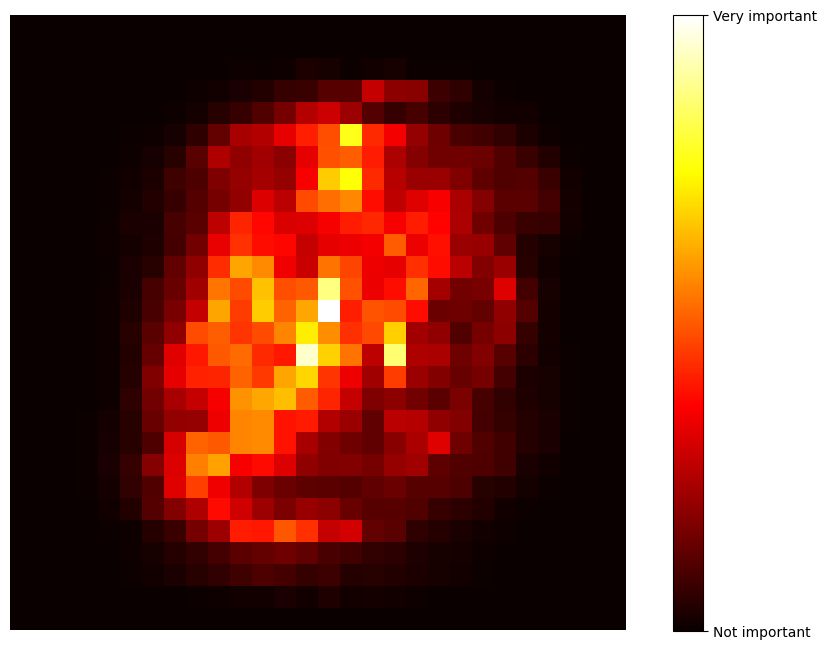

In [32]:
plt.figure(figsize = (12, 8))
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

## 5.2 Define Model Leveraging 70 Pixels

In [36]:
# 70 Pixels Data
train_images_sm = x_train_norm[:,idx]
test_images_sm = x_test_norm[:,idx]

# Build Model
kb.clear_session()
model = Sequential([
    Dense(input_shape=[70], units= 128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Complie Model
model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

#Train Model
history = model.fit(
    train_images_sm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split = 5000 / 60000
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.keras",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )
test_loss, test_acc = model.evaluate(test_images_sm, y_test_encoded)
print('Accuracy: ', test_acc)

Epoch 1/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7608 - loss: 0.9211 - val_accuracy: 0.8902 - val_loss: 0.4574
Epoch 2/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8724 - loss: 0.5082 - val_accuracy: 0.9150 - val_loss: 0.3705
Epoch 3/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8940 - loss: 0.4252 - val_accuracy: 0.9244 - val_loss: 0.3318
Epoch 4/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9045 - loss: 0.3852 - val_accuracy: 0.9320 - val_loss: 0.3096
Epoch 5/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9110 - loss: 0.3578 - val_accuracy: 0.9296 - val_loss: 0.3079
Epoch 6/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9180 - loss: 0.3344 - val_accuracy: 0.9328 - val_loss: 0.2927
Epoch 7/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9213 - loss: 0.3236 - val_accuracy: 0.9374 - val_loss: 0.2835
Epoch 8/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9223 - loss: 0